<a href="https://colab.research.google.com/github/Randhir123/quant/blob/main/TRAINING_CONVOLUTIONAL_NEURAL_NETWORKS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*In this Notebook, we will train a convolutional neural network to predict stock market returns using images of candlestick patterns.*

## **1. LOADING THE DATASET**

As a first step, we will upload the candlestick images. The data correspond with candlestick patterns over 20 days that depict the price evolution of two ETFs, SPY and QQQ. Remember that candlestick plots, in their simplest form, usually include information about the open and close prices at each date, as well as the maximum and minimum prices and volume information, in the bottom part of the plot. The color of the bars identify if there was a price increase (green) or a price decrease (red) during the day. The thinner lines capture the range of prices at which the security has been traded within the day.

Attached to each image, there is a label that determines if the 25-day return after the last date included in each plot has been positive, "up," or negative, "down."

In this application, we are going to test the ability of a CNN to detect patterns in a candlestick plot to predict future returns. In other words, we want to train a network that performs technical analysis and detects visual patterns that may help in the return-prediction problem.

For instance, the image below is associated with a "down" move over the following 25 days.

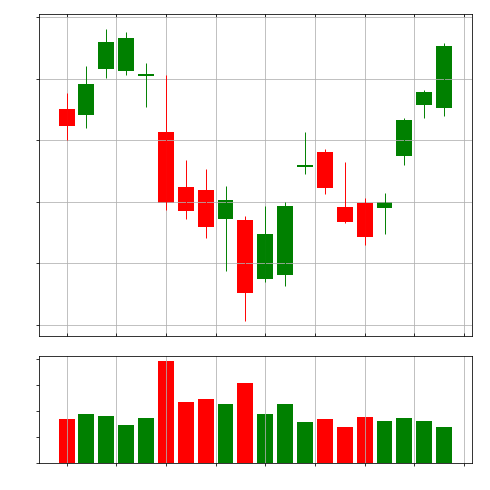

In contrast, the following image is associated with an "up" move over the following 25 days. Will a ConvNet be able to extract relevant information from these images to predict stock returns?

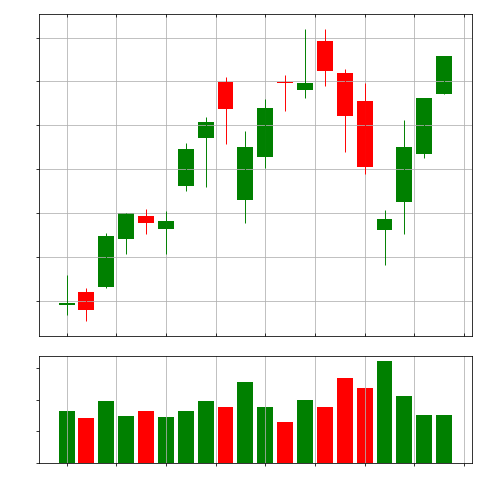

The next block of code loads the TensorFlow-Keras library and reads the data. We process 1,640 images with a size of 250x250 pixels with three channels. The training sample comprises roughly 78% of the sample, while the remaining examples will conform the validation and test sample. In this application, we are going to omit the separation between validation and test, so we are not going to perform any hyperparameter tuning.

In [ ]:
import numpy as np
import tensorflow as tf

tf.random.set_seed(1234)
path_train = "../Candle_Data/Train"
path_test = "../Candle_Data/Test"
# Training sample
train = tf.keras.preprocessing.image_dataset_from_directory(
    path_train, image_size=(250, 250), shuffle=True, label_mode="binary"
)
# Validation sample
test = tf.keras.preprocessing.image_dataset_from_directory(
    path_test, image_size=(250, 250), shuffle=True, label_mode="binary"
)
classes = train.class_names
X_train, y_train = np.array([]).reshape(-1, 250, 250, 3), np.array([]).reshape(-1, 1)
for X, y in train:
    X_train = np.concatenate([X_train, X])
    y_train = np.concatenate([y_train, y])

## **2. BUILDING THE NETWORK'S ARCHITECTURE**


We are going to build the neural network by stacking several convolutional and fully connected layers.

In [2]:
import numpy as np
import tensorflow as tf

model = tf.keras.Sequential()

The architecture's design, similar to AlexNet, contains three layers of convolutions of increasing depth, each of them followed by a 2x2 max-pooling layer. We then combine all the information from the last convolution into a single fully connected layer with dropout.

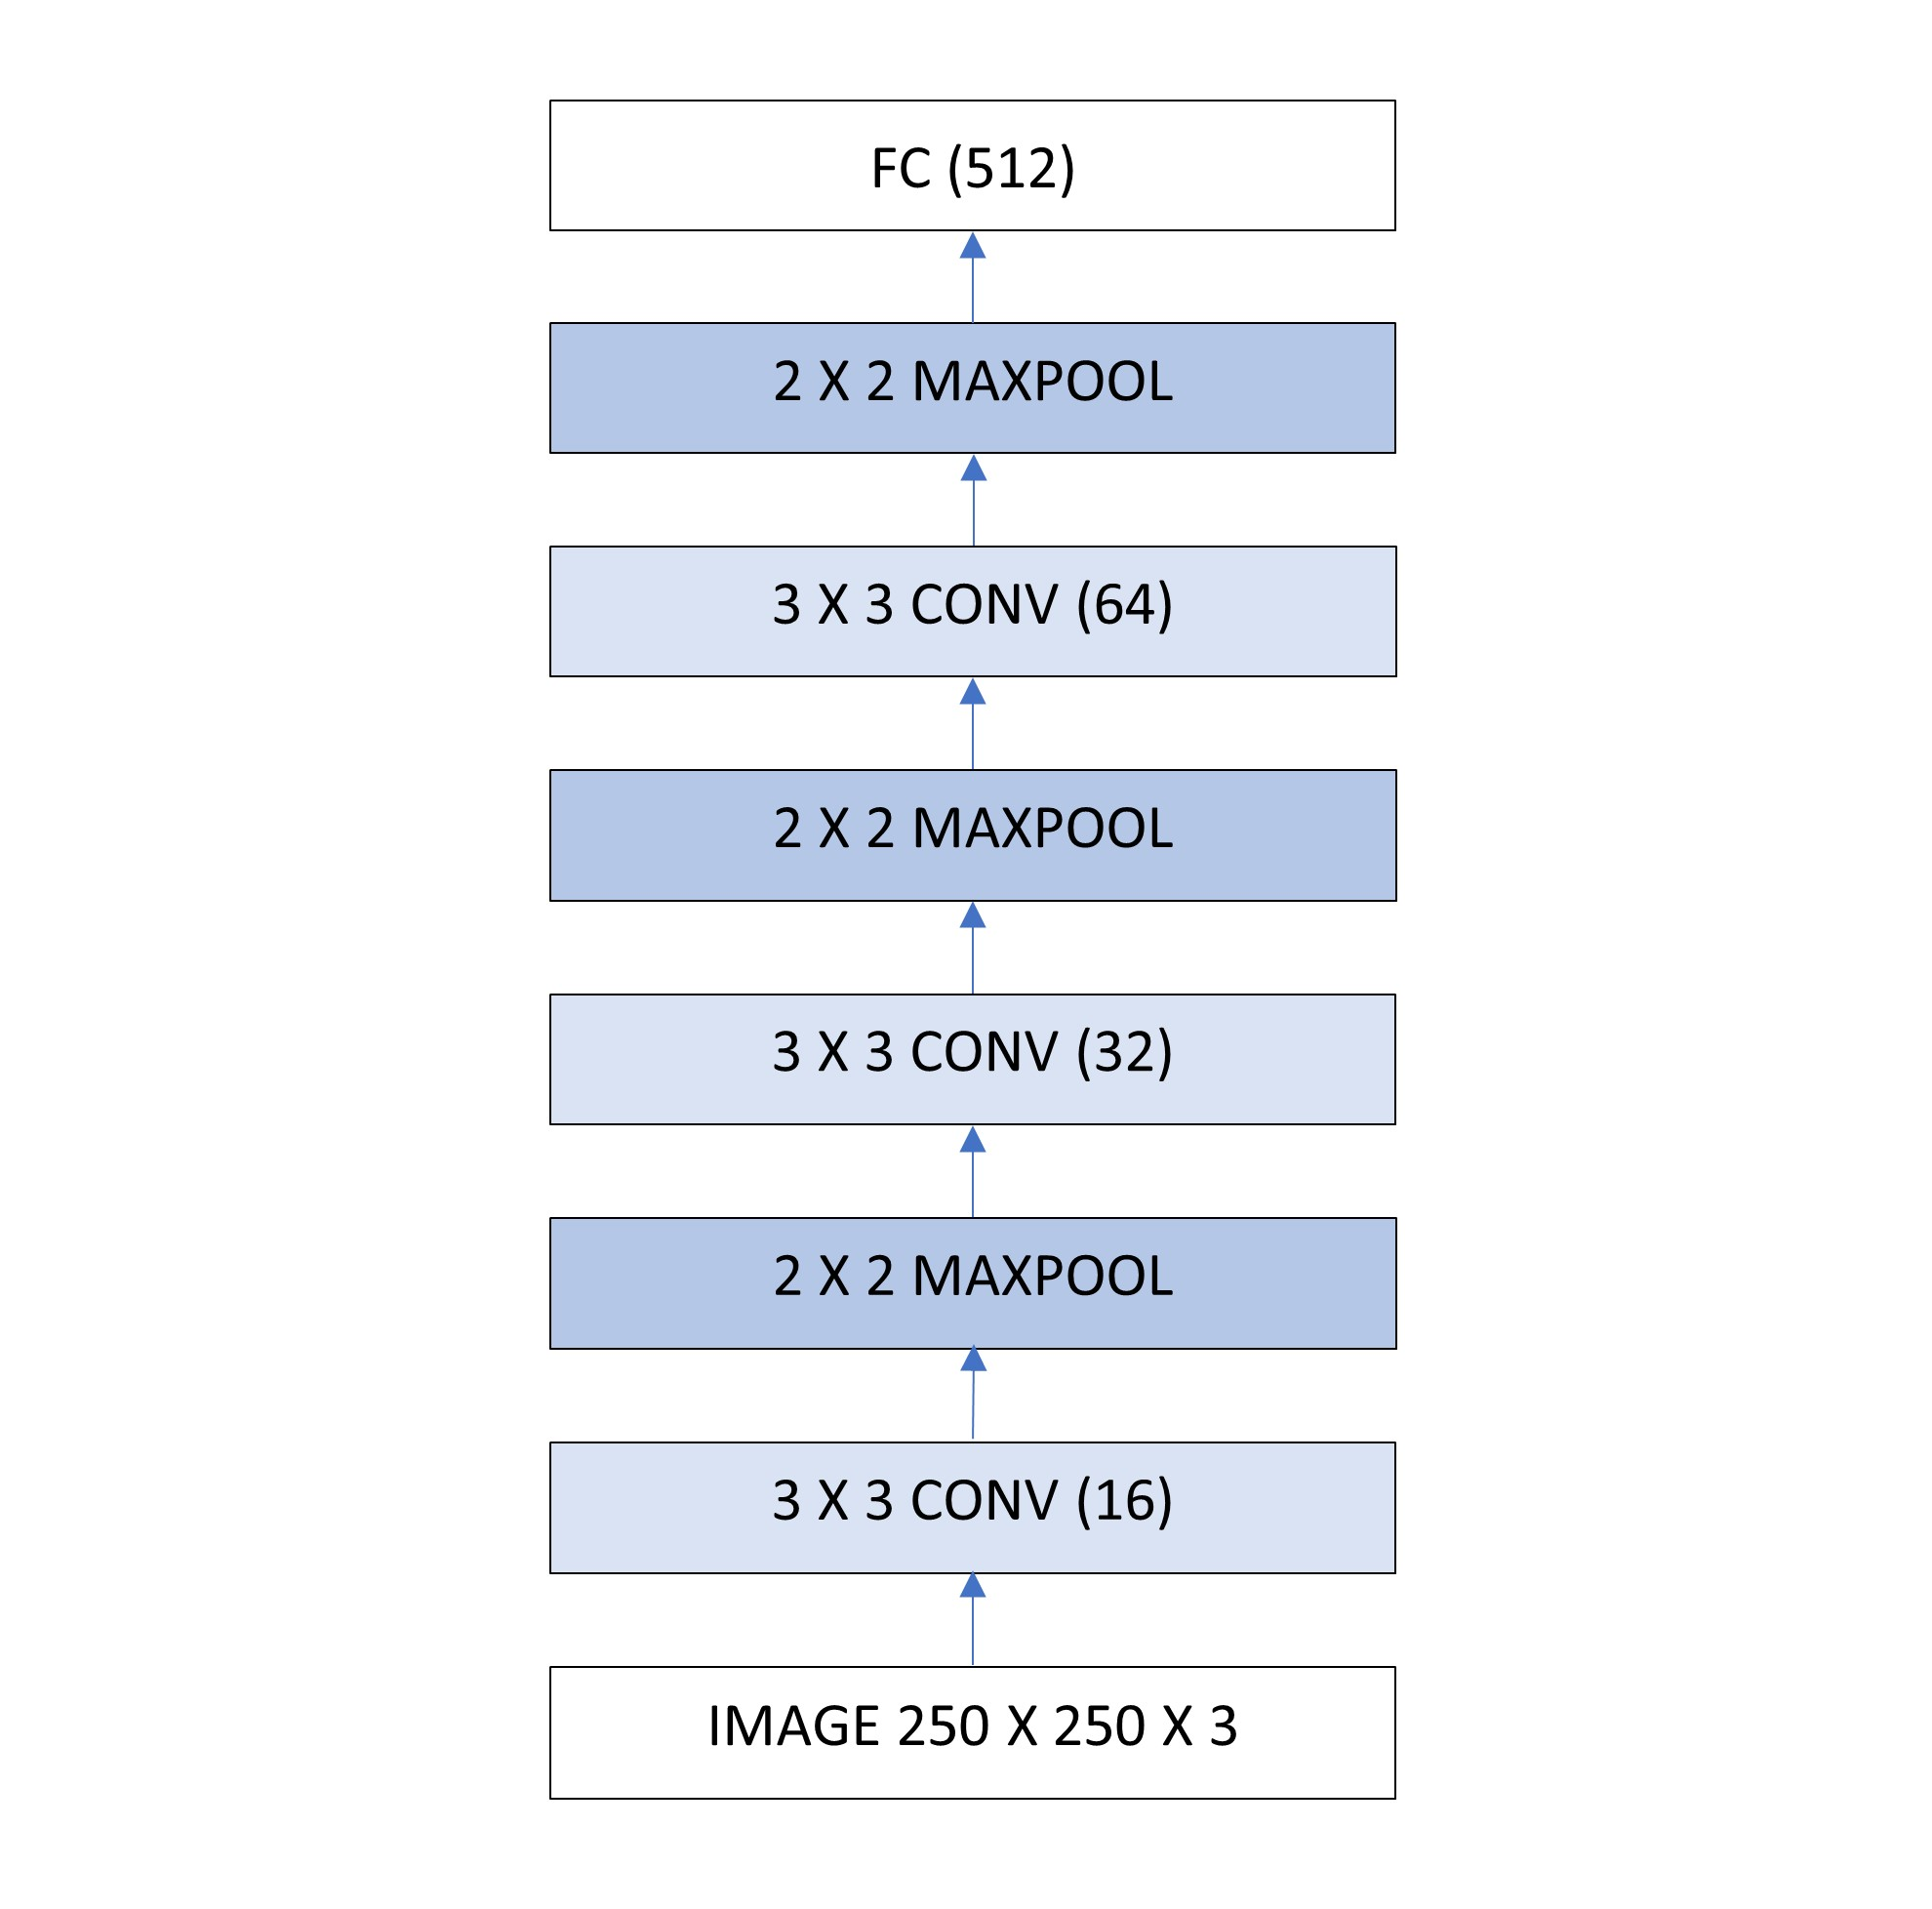

The first component of the network is the input layer that reads the data. Notice that the data is read as a three-dimensional tensor of shape 255x255x3. Before inserting the data into the network, we also rescale the feature values so that they belong to the unit interval (notice that each pixel takes a value between 0 and 255 in each input channel).

In [3]:
# Input layer
model.add(tf.keras.layers.InputLayer(input_shape=(250, 250, 3)))
# Rescaling
model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1.0 / 255))

We first add a convolutional layer with 16 output channels and kernels of size 3x3 (one per input channel). This involves adding a total of 9 parameters per kernel times 3 input channels times 16 output channels, plus 16 biases, which equals 448 trainable parameters in total. Below, when we compile the model, we will observe a summary of all the layers and parameters that are included in the model.

After applying the convolution, we use a ReLU activation and then the first 2x2 max-pooling layer.

In [4]:
model.add(tf.keras.layers.Conv2D(16, 3, activation="relu"))
model.add(tf.keras.layers.MaxPooling2D(2))

The second convolutional layer again contains kernels of size 3x3 and 32 output channels.

In [5]:
model.add(tf.keras.layers.Conv2D(32, 3, activation="relu"))
model.add(tf.keras.layers.MaxPooling2D(2))

The last convolutional layer produces 64 output channels.

In [6]:
model.add(tf.keras.layers.Conv2D(64, 3, activation="relu"))
model.add(tf.keras.layers.MaxPooling2D(2))

Next, we reshape the information contained in the output layer from the last convolution-pooling step to include it in a final, fully connected layer with 512 neurons (hidden representations). The fully connected layer also applies a ReLU activation function. We apply a dropout rate of 0.5, which means that input units to the next layer take a value of 0 with a 50% frequency.

In [7]:
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(512, activation="relu"))
model.add(tf.keras.layers.Dropout(0.5, seed=1234))

We finally define the output layer with a single neuron and a sigmoid activation, which is the natural choice given our classification problem with two categories.

In [8]:
model.add(tf.keras.layers.Dense(1, activation="sigmoid"))

We can now obtain a table that summarizes the full structure of the network.

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 250, 250, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 248, 248, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 124, 124, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 122, 122, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 61, 61, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 59, 59, 64)        1

Feel free to change the architecture of the model in any of its dimensions and evaluate the change in performance. You have plenty of adjustments to play around with: size and color of the input images, number of layers, size of kernels, number of output channels, etc.

You can also embed batch normalization layers as we described in lesson 3 after each convolution. To do this, we first add a convolutional layer, without activation, and then add the batch normalization layer, followed by an activation layer. We show how to do this in the image below.

*Note: In practice, batch normalization includes two additional non-trainable parameters per channel. The mean and variance applied in the normalization arises from a rolling average using previous estimates, where a parameter called "momentum" governs the relevance of past estimates. Moreover, the denominator in the normalization term includes a small number to avoid divisions by zero.*

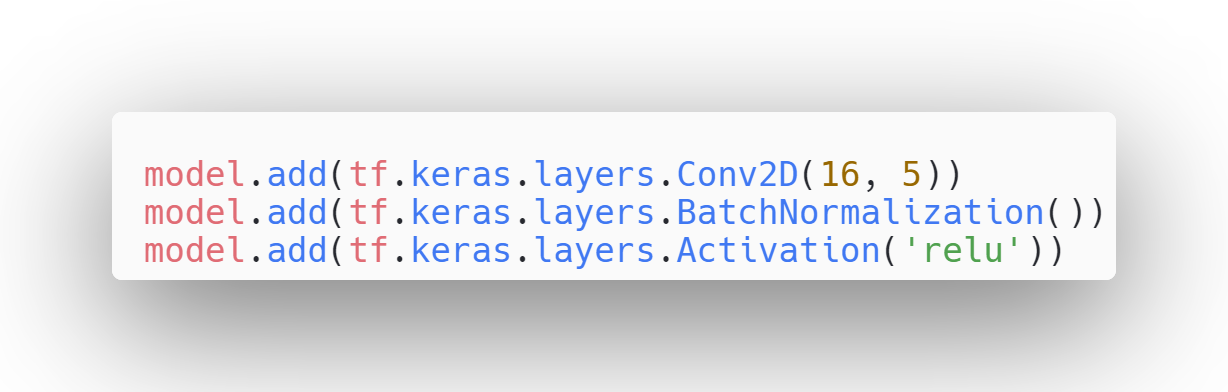

## **3. TRAINING THE MODEL**

To train the model, we first compile all the layers defined above and configure the model for training. We choose RMSprop for our optimizer and the usual binary crossentropy function as our objective function. We also set that, at each step of the optimization, the code informs us about the accuracy achieved by the model.

In [10]:
model.compile(loss="binary_crossentropy", optimizer="RMSprop", metrics=["accuracy"])

Before training the model, we save a checkpoint through a callback that will save the Keras model that reaches the highest accuracy during training. The model information will be stored in a file 'model.h5' in our directory.

In [11]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "model.h5", monitor="val_accuracy", save_best_only=True, mode="auto"
)

One of the key aspects to successfully train a neural network is to use a balanced sample across labels when training. In our particular case, we cannot fine-tune the composition of the training sample between "ups" and "downs." To overcome this, we will explicitly weight the "down" labels, which are the less frequent category, by the inverse of its frequency. In other words, we are telling the model to "pay more attention" to samples from an under-represented category.

In [ ]:
class_weight = {0: 1 / np.mean(y_train), 1: 1.0}
print(class_weight)

Finally, we have reached the training step for our CNN. We tell the method "fit" to use the training images (and associated labels) for 20 epochs and using the test sample as validation set. By default, the batch size is of 32 examples, and we overweight "down" labels as determined above. We also tell the method to show progress bars by setting the value of "verbose."

In [ ]:
model.fit(
    train,
    epochs=20,
    validation_data=test,
    verbose=1,
    callbacks=[checkpoint],
    class_weight=class_weight,
)

## **4. EVALUATING THE MODEL'S PERFORMANCE**

So now that we have trained the network over 20 epochs, we're ready to evaluate the performance of the best model, as measured by its accuracy over the validation set. For this, we first load the model we told Keras to save in our directory during training.

In [ ]:
model = tf.keras.models.load_model("model.h5")

Let's display the accuracy reached in the validation sample (recall that we are not using a test sample; the validation and test are the same).

In [ ]:
acc = model.evaluate(test)
print("Accuracy over validation: {:.2f}%".format(acc[1] * 100))

The best model trained over the 20 epochs should reach an accuracy in the order of 55% to 58%. As we already know, accuracy may not be an informative measure of performance, as the model may be predicting that the stock will be going "down" for most examples, and the stock may actually go "down" by an amount equivalent to the accuracy of the model.

Below, we build our arrays of training inputs and labels to construct the confusion matrix and compute our already-familiar performance indicators. The model seems to have a slight predictive ability. However, it predicts that prices go "down" most of the time, while in many cases the price goes "up."


In [ ]:
from sklearn import metrics
from sklearn.metrics import classification_report

X_test, y_test = np.array([]).reshape(-1, 250, 250, 3), np.array([]).reshape(-1, 1)
for X, y in test:
    X_test = np.concatenate([X_test, X])
    y_test = np.concatenate([y_test, y])
y_prob = model.predict(X_test)
y_pred = np.round(y_prob)
cm = metrics.confusion_matrix(y_test, y_pred)
cm = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
cm.plot(values_format="", cmap="Blues")
print(classification_report(y_test, y_pred))

## **5. CONCLUSION**

With this, we finalize Module 2 on convolutional neural networks, which has served as an introduction to the main concepts and design of architectures to obtain predictions from images. In Module 3 of this course, we will describe several tools that may help us to improve and enhance the performance of our CNNs.